In [7]:
import numpy as np
import psi4
from matplotlib import pyplot as plt


In [8]:
# fonction calcul X=Us^-1/2U^dagger à partir de matrice overlap S, une matrice overlap n'a que des
# valeurs propres strictement positives (définie positive), donc pas de problèmes pour calculer s=np.diag(1/np.sqrt(evalues))

    
def verif_X_matrix(X,S):
    Xh=np.conjugate(X.T)
    n=len(X)
    verif=np.matmul(Xh,np.matmul(S,X))
    if (abs(verif-np.identity(n))<10**-14).all():
        return True
    else:
        return(False)
##
def X_matrix(S):
    evalues,U= np.linalg.eigh(S) 
    s=np.diag(1/np.sqrt(evalues))#matrice diagonale avec l'inverse des racines des valeurs propres

    X=np.matmul(np.matmul(U,s),np.conjugate(U.T)) #X=Us^(-1/2)U*
    if verif_X_matrix(X,S):
        return(X)
    else: 
        return('error')
##

In [9]:
#Calcul de F a l'aide de la matrice densité F= H + G
def G_matrix(P,v):
    n=len(P)
    G=np.zeros((n,n))
    for i in range(n):
        for j in range(n):
            G_ij=0
            for k in range(n):
                for l in range(n):
                    G_ij+=P[k,l]*(v[i][j][k][l]-0.5*v[i][l][k][j])
            G[i,j]=G_ij
    return(G)
    
#fonction calcul  F'=X*FX

def new_fock_matrix(F,X):
    FX=np.matmul(F,X)
    return(np.matmul(np.conjugate(X.T),FX))
##

In [10]:
#calcul matrice C des coefs

def coef_matrix(f,X):
    energy,c=np.linalg.eigh(f)
    C=np.matmul(X,c)
    return(C)

In [11]:
#calcul nouvelle matrice densité
#def new_density_matrix(C):
#    return(2*np.matmul(C,np.conjugate(C.T)))

def new_density_matrix(C,Bas_n,N):
    P=np.zeros_like(C)
    Cd=np.conjugate(C.T)
    for i in range(Bas_n):
        for j in range(Bas_n):
            for a in range(int(N/2)):
                P[i,j]+=2*C[i,a]*C[j,a]

    
    return(P)

In [12]:
#convergence de l'algo avec le commutateur
def convergence(F,P,S,lim):
    if (P==0).all():
        return False
    FPS=np.matmul(F,np.matmul(P,S))
    SPF=np.matmul(S,np.matmul(P,F))
    if (abs(FPS-SPF)<=lim).all():
        return True
    else:
        return False
    

    

In [13]:
def SCF_procedure_energy(S,v,H,Bas_n,N,lim,max_iter):
    #initialisation
    X=X_matrix(S)
    P=np.zeros_like(H)
    n_iter=0
    
    #Boucle convergence
    while (n_iter<max_iter):

        #Matrice de fock
        G=G_matrix(P,v)
        F=H+G
        #convergence
        if convergence(F,P,S,lim):
            break
        
        f=new_fock_matrix(F,X)
        C=coef_matrix(f,X)
        P=new_density_matrix(C,Bas_n,N)
        n_iter+=1
    return(0.5*np.trace(np.matmul(P,H+F))+mol.nuclear_repulsion_energy())

In [14]:
psi4.set_memory('500 MB')
#liste de distance et listes pour les énergies
Dist_list=np.linspace(0.1,5,num=50)
Energy_list=[]
Energy_list2=[]


for Dist in Dist_list:
    # géométrie de la molécule
    mol = psi4.geometry("""
    H  0.0  0.000000  0.0
    H  """+ str(Dist) +"""  0.000000  0.0

    """)


    geo_unit = psi4.core.GeometryUnits(0) # Angstrom:0 , bohr:1
    null=psi4.core.Molecule.set_units(mol,geo_unit)
    null=psi4.core.Molecule.set_molecular_charge(mol,0)
    null=psi4.core.Molecule.set_multiplicity(mol,1)
    #Fonction d'onde de la molécule
    wf = psi4.core.Wavefunction.build(mol,basis='sto-3g')
    mints = psi4.core.MintsHelper(wf.basisset())

    #différentes intégrales calculées par psi4
    S = np.array(mints.ao_overlap())
    v = np.asarray(mints.ao_eri())
    T = np.asarray(mints.ao_kinetic())
    V = np.asarray(mints.ao_potential())
    H=T+V
    
    #Différents paramètres pour l'algo
    Bas_n = S.shape[0]
    N= int(2*wf.nalpha())
    lim=10**(-14)
    max_iter=20
    #calcul des énergies
    Energy=SCF_procedure_energy(S,v,H,Bas_n,N,lim,max_iter)
    Energy2=(psi4.energy('hf/sto-3g'))
    Energy_list.append(Energy)
    Energy_list2.append(Energy2)

print(np.asarray(Energy_list)-np.asarray(Energy_list2))

[ 7.79443354e-05  4.90568060e-05  2.52480362e-05  2.25666511e-05
  2.65047378e-05  2.63236140e-05  2.44729963e-05  2.38274444e-05
  2.46765531e-05  2.69170517e-05  3.18335585e-05  4.09056940e-05
  5.35038687e-05  6.68864893e-05  7.84884813e-05  8.75263984e-05
  9.46370682e-05  1.00797362e-04  1.06685487e-04  1.12577950e-04
  1.18472959e-04  1.24230090e-04  1.29664772e-04  1.34602075e-04
  1.38905403e-04  1.42490200e-04  1.45327529e-04  1.47440091e-04
  1.48892782e-04  1.49779998e-04  1.50211886e-04  1.50301535e-04
  1.50154582e-04  1.49862070e-04  1.49496668e-04  1.49112076e-04
  1.48744217e-04  1.48414401e-04  1.47815307e-04  1.45376572e-04
  1.29047179e-04  1.47572932e-04 -3.05959190e-03 -1.69649673e-02
 -6.36559024e-02  1.47282545e-04 -1.55629005e-01 -2.03958451e-01
 -2.20890581e-01  1.47207220e-04]


In [ ]:
plt.plot(Dist_list, np.asarray(Energy_list))



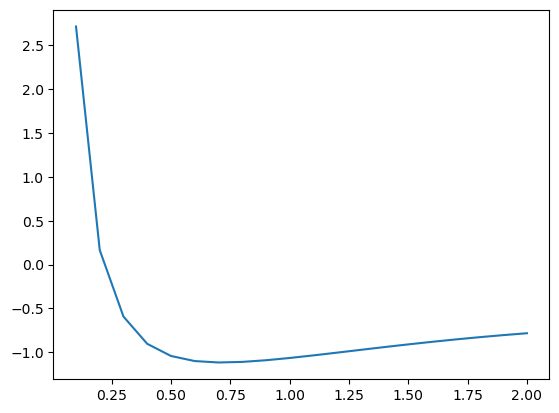

In [21]:
plt.plot(Dist_list,np.asarray(Energy_list))

In [31]:
A=np.array([[1,0,0],[0,1,0],[0,0,1]])
B=A
B.power(2)
print(B)

AttributeError: 'numpy.ndarray' object has no attribute 'power'